In [37]:
# imports

import numpy as np
import matplotlib.pyplot as plt

# Setting up the System

This section defines the assembly matrix for the discretized equation
$$
\frac{\partial^2 T}{\partial x^2} = \alpha e^{\beta (x-0.5)^2}
$$
using an FVM Gauss linear, no correction approach; notation from Moukalled et al.

A Dirichlet condition of $T=100$ is set at the origin; this can be thought of as a heat plate or base.
A Neumann condition specifying a constant flux rate of $q=10$ is set at $x=1.0$.
A Gaussian distribution-like source term is focused in the center with vary narrow variance.

In [38]:
# Define the system
# One-dimensional steady heat diffusion with source

nnodes = 100
k = 0.10
delta_x = 1.0 / nnodes
Tb1 = 100.0
qb2 = 10.0
Tb2 = 0.0

def source(x):
    return 100*np.exp(-100.0*(x-0.5)**2)

# Neighbors as [W,E]
neighbors = {}
for i in range(2,nnodes):
    neighbors[i] = [i-1,i+1]
neighbors[1] = ['b1',2]
neighbors[nnodes] = [nnodes-1,'b2']

startx = delta_x / 2
centroids = {}
count = 0
for i in range(1,nnodes+1):
    centroids[i] = startx + count*delta_x
    count += 1

In [39]:
# Assembly Matrix (Finite Volumes)

A = np.zeros((nnodes,nnodes))
b = np.zeros(nnodes)

for i in range(1,nnodes+1):
    W,E = neighbors[i]
    # Internal
    if type(W) == type(1) and type(E) == type(1):
        A[i-1,i-1] = 2*k/delta_x
        A[i-1,W-1] = -k/delta_x
        A[i-1,E-1] = -k/delta_x
        b[i-1] = 0.0 + delta_x*source(centroids[i])
    # Boundary
    elif type(W) == type('b1'):
        A[i-1,i-1] = 3*k/delta_x
        A[i-1,E-1] = -k/delta_x
        b[i-1] = 2*k*Tb1/delta_x + delta_x*source(centroids[i])
    else:
        A[i-1,i-1] = k/delta_x
        A[i-1,W-1] = -k/delta_x
        b[i-1] = -qb2 + delta_x*source(centroids[i])

In [40]:
# Gauss-Seidel Smoother (O(n^2 implementation, runs in O(n)))

def gaussSeidel(A, b, init_guess, max_iter=10):
    # initial guess
    T = init_guess*0 + init_guess
    assert T.shape[0] == A.shape[0]

    for i in range(A.shape[0]):
        sumt = 0
        for j in range(A.shape[0]):
            if j != i:
                sumt += A[i,j] * T[j]
        T[i] = (b[i] - sumt) / A[i,i] 

    iter = 1
    while (iter < max_iter):
        for i in range(A.shape[0]):
            sumt = 0
            for j in range(A.shape[0]):
                if j != i:
                    sumt += A[i,j] * T[j]
            T[i] = (b[i] - sumt) / A[i,i] 
        iter += 1
    return T, b-A@T

# Multigrid Algorithm
This section defines constructors for restriction and prolongation interpolation profiles based on injection: in injection, we define the new residual of a cell on the coarse grid as the sum of the resdiuals of its constituent fine grid cells. The first row in R will look like:
$$
[1, 1, 0, 0, ..., 0]
$$
The prolongation profile is a simply assigning the coarse cell value to its fine grid constituent cells, i.e.
$$
R_{fine}^1,R_{fine}^2 := R_{coarse}^1
$$

In [41]:
# Create Restriction Matrix and Prolongation matrix given a dimension (must be even for injection method)

def restrictionMatrix(dimension):
    if dimension % 2 != 0:
        raise Warning
    # Restriction Matrix
    R = np.zeros((int(dimension/2),dimension))
    i = -1
    for j in range(dimension):
        if j % 2 == 0:
            i += 1
        R[i,j] = 1.0

    # Prolongation matrix (using the injection method)
    P = 0*R.T + R.T
    return R, P

In [42]:
# Multigrid Algorithm

tol = 1e-10

# Track residuals: key is number of iter
residuals = {}
current_iter = 0

iter_count = 0
converged = False

# init guess
Te = np.zeros(nnodes)

# introduce artifical error
for i in range(nnodes):
    Te[i] += (-1.0)**i

# Get the restriction/prolongation matrices
R, P = restrictionMatrix(A.shape[1])

while (not converged):
    # Perform Gauss-Seidel on Ax=b to get x
    Te, resid = gaussSeidel(A, b, Te, max_iter=5)
    current_iter += 5
    residuals[current_iter] = resid

    # Calculate residual r=b-Ax
    r = b-A@Te

    # Calculate A'(Dx)'=r' on the coarser grid
    A_prime = R@A@P
    r_prime = R@r
    DT_prime, resid = gaussSeidel(A_prime, r_prime, init_guess=np.zeros(int(nnodes/2)), max_iter=5)
    current_iter += 5
    residuals[current_iter] = resid

    # Prolongate back to finer grid

    # Update xnew=x+Dx
    Te = Te + P@DT_prime

    # Gauss-Seidel smoothing
    Te, resid = gaussSeidel(A, b, init_guess=Te, max_iter=5)
    current_iter += 5
    residuals[current_iter] = resid

    if (np.linalg.norm(resid) < tol):
        converged = True
    iter_count += 15

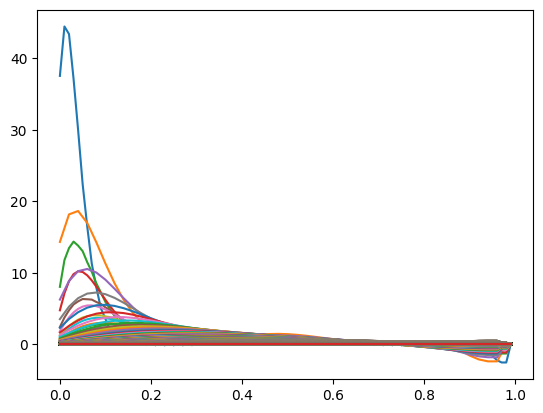

In [7]:
# View how the residuals change over all iterations

r_norms = []
for i in residuals.keys():
    plt.plot(np.arange(len(residuals[i]))/len(residuals[i]), residuals[i], label="iter " + str(i))
    if i % 20 == 0:
        r_norms.append(np.linalg.norm(residuals[i]))

# Analysis

Here we demonstrate empirically that two-level converges in less iterations than the naive Gauss-Seidel iterate-until-convergence approach.

In [34]:
# Gauss-Seidel Smoother for the naive approach (O(n^2 implementation, runs in O(n)))

tol = 1e-10

def gaussSeidelNaive(A, b, init_guess, max_iter=10):
    # initial guess
    T = init_guess*0 + init_guess
    assert T.shape[0] == A.shape[0]

    for i in range(A.shape[0]):
        sumt = 0
        for j in range(A.shape[0]):
            if j != i:
                sumt += A[i,j] * T[j]
        T[i] = (b[i] - sumt) / A[i,i] 

    iter = 1
    while (np.linalg.norm(b-A@T)>tol and iter < max_iter): # Here we give a tolerance condition as well
        for i in range(A.shape[0]):
            sumt = 0
            for j in range(A.shape[0]):
                if j != i:
                    sumt += A[i,j] * T[j]
            T[i] = (b[i] - sumt) / A[i,i] 
        iter += 1
    return T, b-A@T, iter

In [35]:
# Compare to pure Gauss Seidel

tol = 1e-10

iter_count_naive = 0
converged = False

# init guess
Te = np.zeros(nnodes)

# introduce artificial error
for i in range(nnodes):
    Te[i] += (-1.0)**i

gs_rnorms = []

while (not converged):
    Te, resid, iters = gaussSeidelNaive(A, b, Te, max_iter=10)
    gs_rnorms.append(np.linalg.norm(resid))
    gs_rnorms.append(np.linalg.norm(resid))
    if (np.linalg.norm(resid) < tol):
        converged = True
    if iters != 10:
        iter_count_naive += 10
    else:
        iter_count_naive += iters

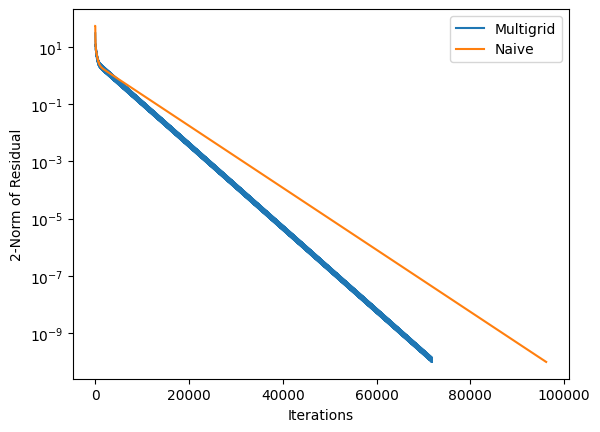

In [43]:
# Compare the number iterations needed to converge

fig,ax = plt.subplots()
ax.plot(np.arange(len(r_norms))/len(r_norms) * iter_count, r_norms, label='Multigrid')
ax.plot(np.arange(len(gs_rnorms))/len(gs_rnorms) * iter_count_naive, gs_rnorms, label='Naive') # This will be slightly off, but only at the very end when we approach convergence
ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("2-Norm of Residual")
ax.legend()

# View the $x$-Temperature Profile

Here we show the final temperature profile in the pipe!

Text(0, 0.5, 'Temperature')

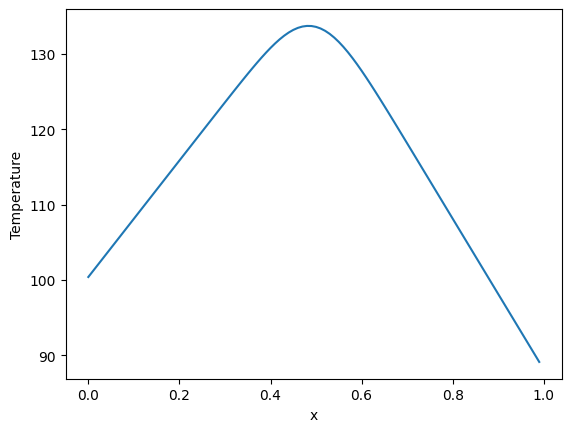

In [29]:
plt.plot(np.arange(nnodes)/nnodes,Te)
plt.xlabel("x")
plt.ylabel('Temperature')